# Human colon cancer data analysis
Python analysis using scanpy.


## Setup

In [28]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scanorama
import scipy
import os
import anndata as anndata
import decoupler as dc
from pathlib import Path
import gzip, shutil

In [2]:
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [73]:
path_to_results = Path('../results/')
path_to_results.mkdir(parents=True, exist_ok=True)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize = (4,4), dpi_save=300, frameon = False)
sc.settings.figdir = path_to_results
umap_point_size = 10
umap_transparency = 0.3
umap_continuous_point_size = 50
umap_continuous_transparency = 0.7
aspect_ratio = 1
save_figure = False

scanpy==1.9.2 anndata==0.9.2 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 louvain==0.8.1 pynndescent==0.5.10


# Data import
#Read the 10X dataset with count matrices.

In [6]:
results_file = '../data/intermediate/preprocessed.h5ad'
data_path = Path('../data/raw/')
data_path.mkdir(parents = True, exist_ok = True)
intermediate_data_path = Path('../data/intermediate')
intermediate_data_path.mkdir(parents = True, exist_ok = True)
annotated_tpm_file = os.path.join(intermediate_data_path, 'tpm.h5ad')

In [7]:
adata = sc.read(data_path / 'adata_AllAnnotated.h5ad') # downloaded from  https://doi.org/10.6084/m9.figshare.25323397 ; article: https://www.nature.com/articles/s43018-024-00807-z

In [8]:
adata.obs.Sample.unique()

['scrEXT001.counts.csv', 'scrEXT002.counts.csv', 'scrEXT003.counts.csv', 'scrEXT009.counts.csv', 'scrEXT010.counts.csv', ..., 'C171_TA_1_1_1_c1_v3', 'C171_TB_1_1_0_c1_v3', 'C171_TB_1_1_1_c1_v3', 'C172_T_0_0_0_c1_v3', 'C173_T_0_0_0_c1_v3']
Length: 460
Categories (460, object): ['290b', '298c', '302c', '390c', ..., 'scrEXT026.counts.csv', 'scrEXT027.counts.csv', 'scrEXT028.counts.csv', 'scrEXT029.counts.csv']

In [9]:
adata

AnnData object with n_obs × n_vars = 671192 × 51971
    obs: 'Sample', 'Dataset', 'Patient', 'Class', 'SubCluster', 'MMRstatus', 'Position', 'Site', 'Grade', 'GrandparentalCluster', 'ParentalCluster', 'nCount_RNA', 'nFeature_RNA'
    var: 'name'
    obsm: 'X_umap'

In [10]:
adata.var_names

Index(['RP11-34P13.7', 'FO538757.2', 'AP006222.2', 'RP4-669L17.10',
       'RP11-206L10.9', 'FAM87B', 'LINC00115', 'FAM41C', 'RP11-54O7.3',
       'SAMD11',
       ...
       'AC006032.1', 'Y-RNA.802', 'FAM197Y8', 'RNA5-8SP6', 'RN7SL702P',
       'AC010879.1', 'NCRNA00185', 'AC006328.1', 'RP11-341D18.3',
       'RP11-555K2.3'],
      dtype='object', length=51971)

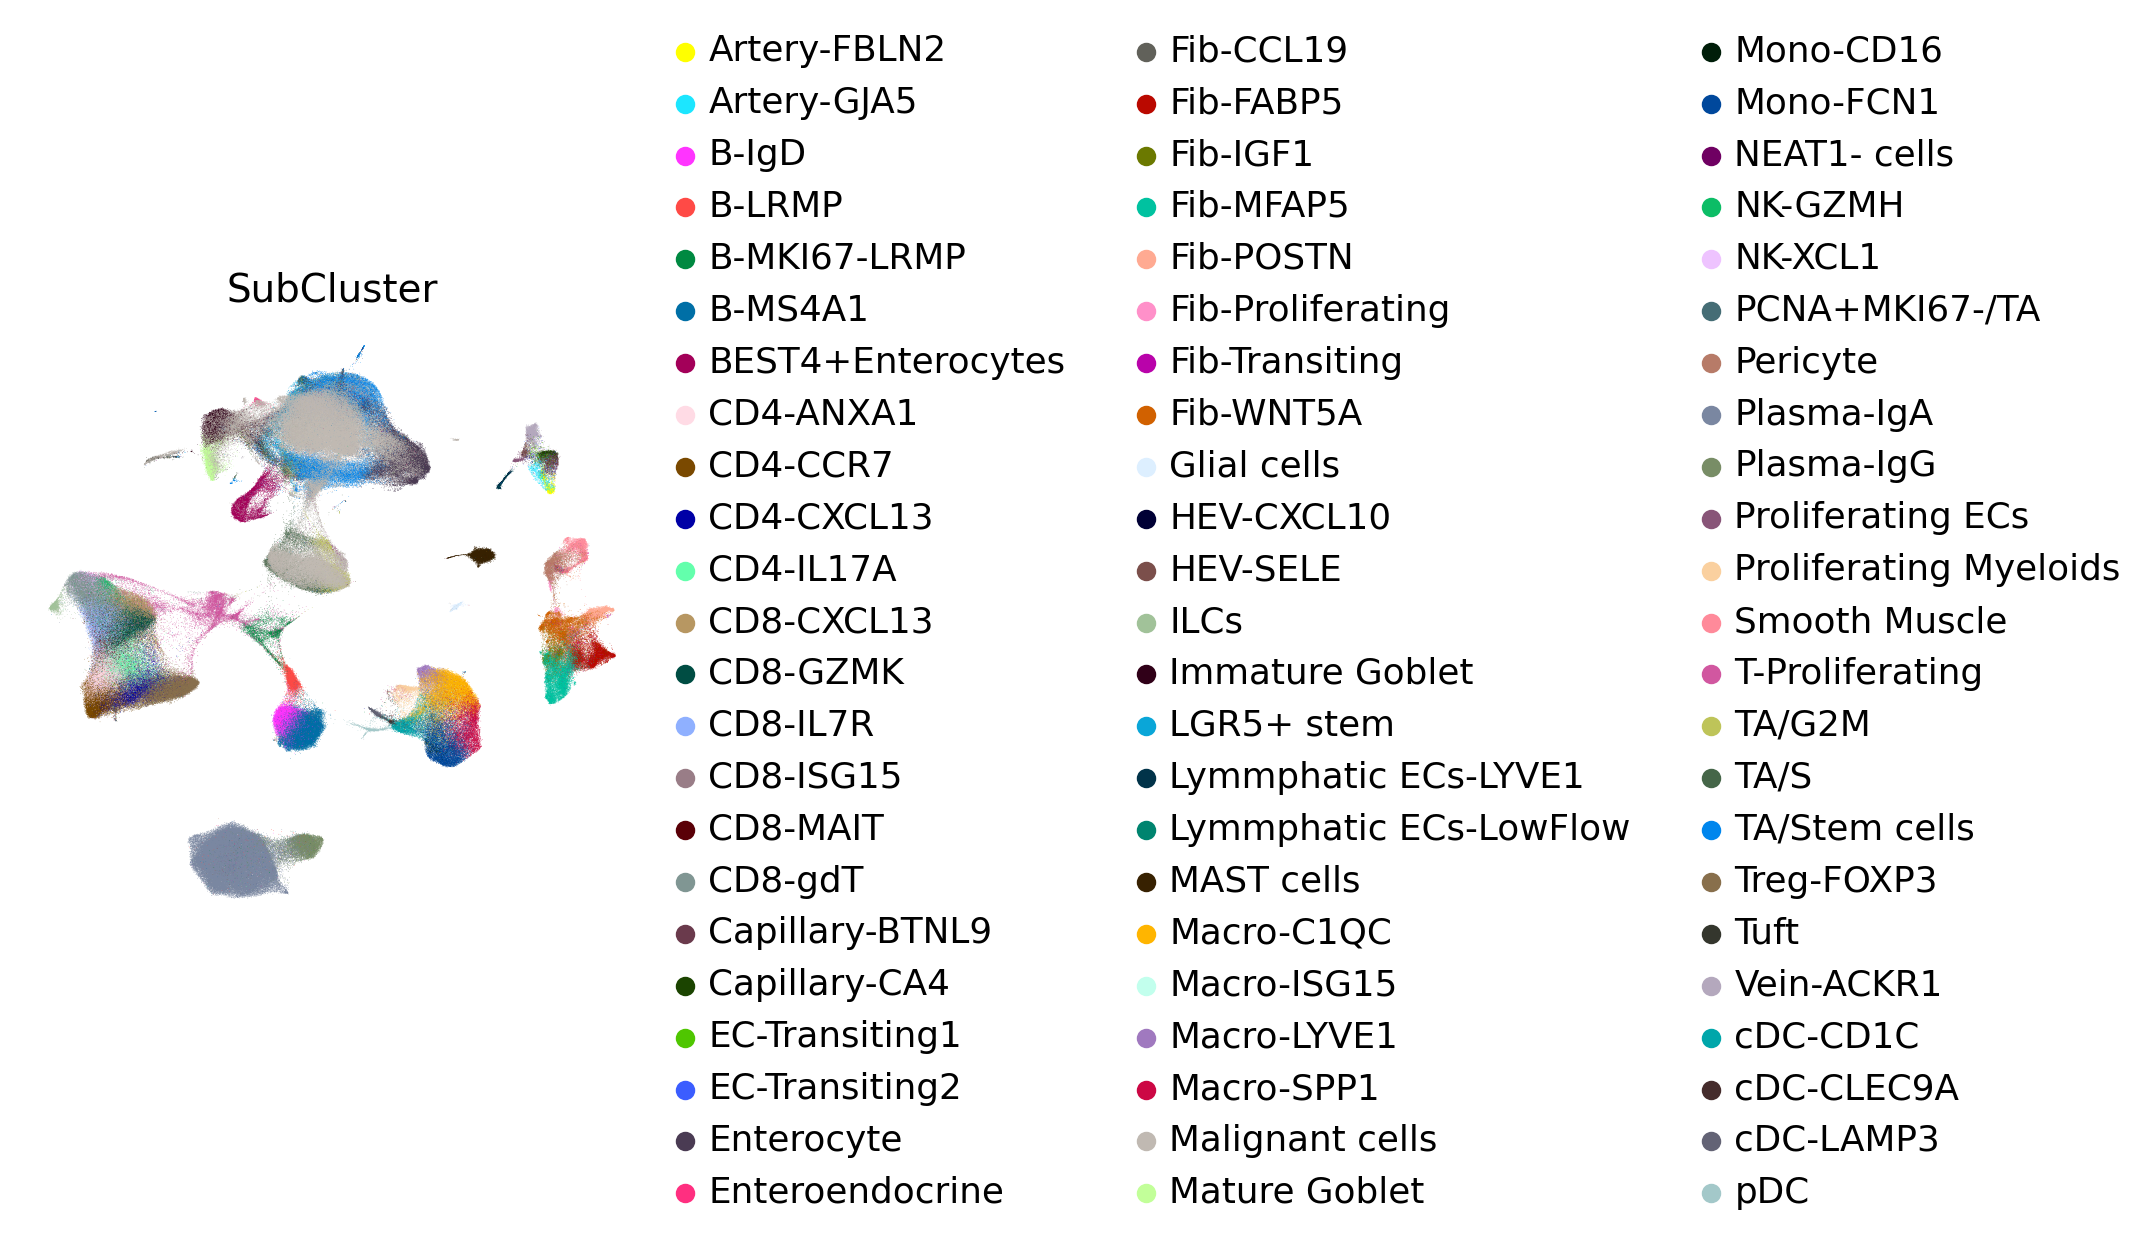

In [11]:
sc.pl.umap(adata, color = ['SubCluster'])

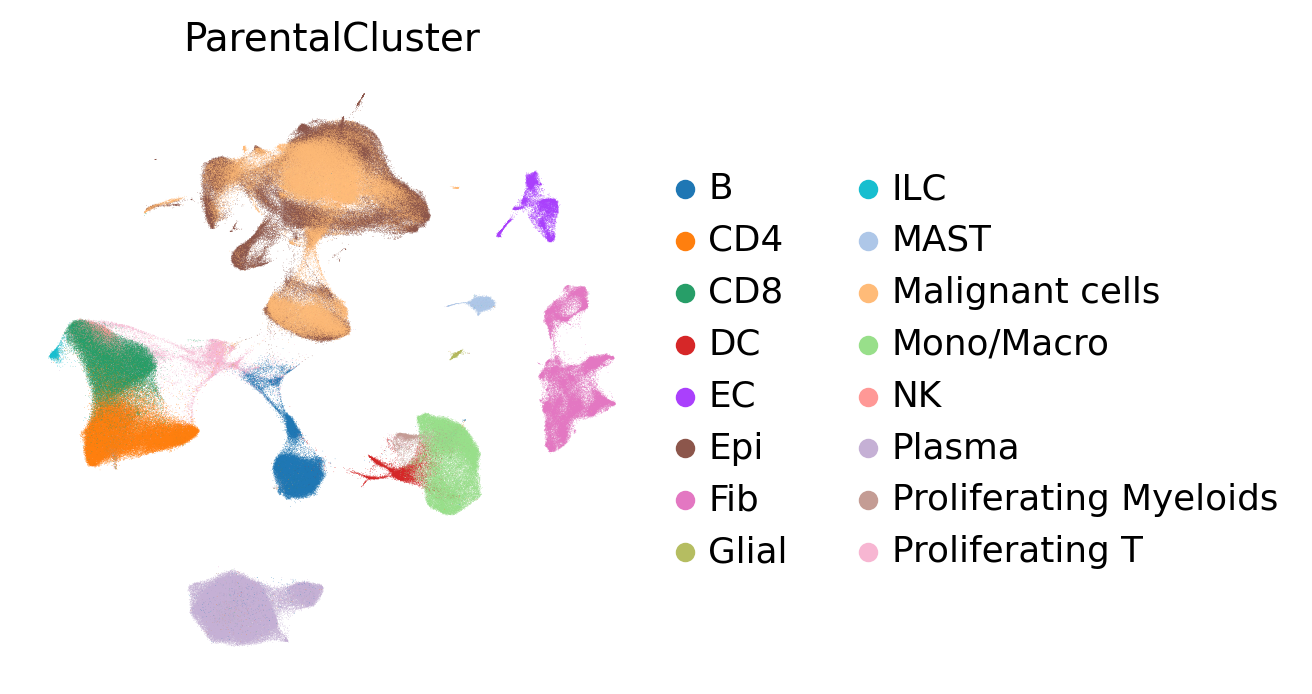

In [12]:
sc.pl.umap(adata, color = ['ParentalCluster'])

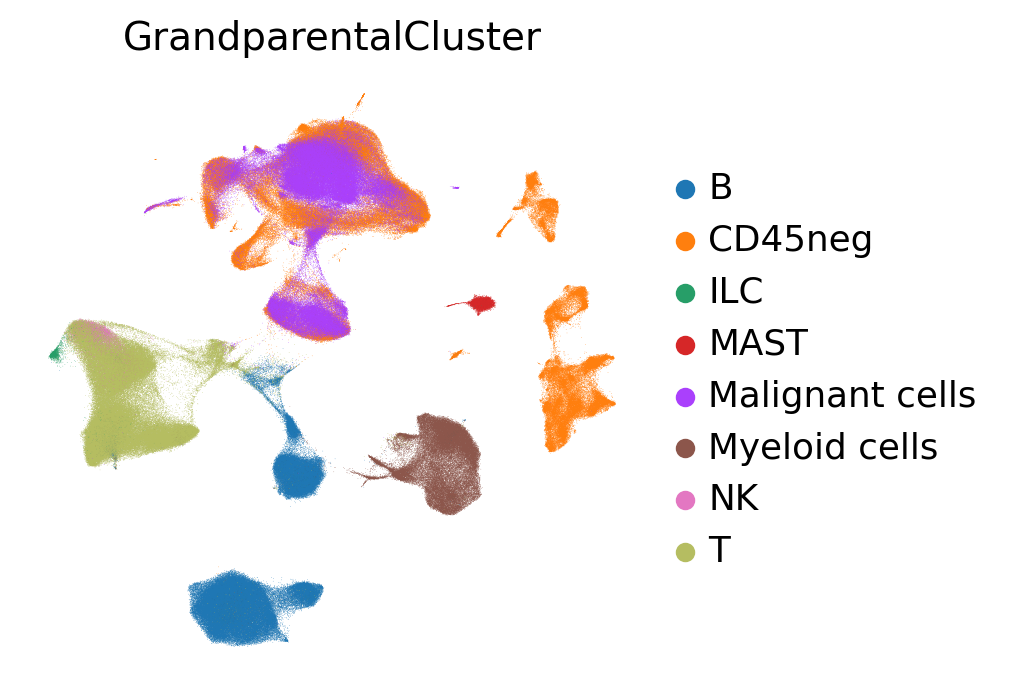

In [13]:
sc.pl.umap(adata, color = ['GrandparentalCluster'])

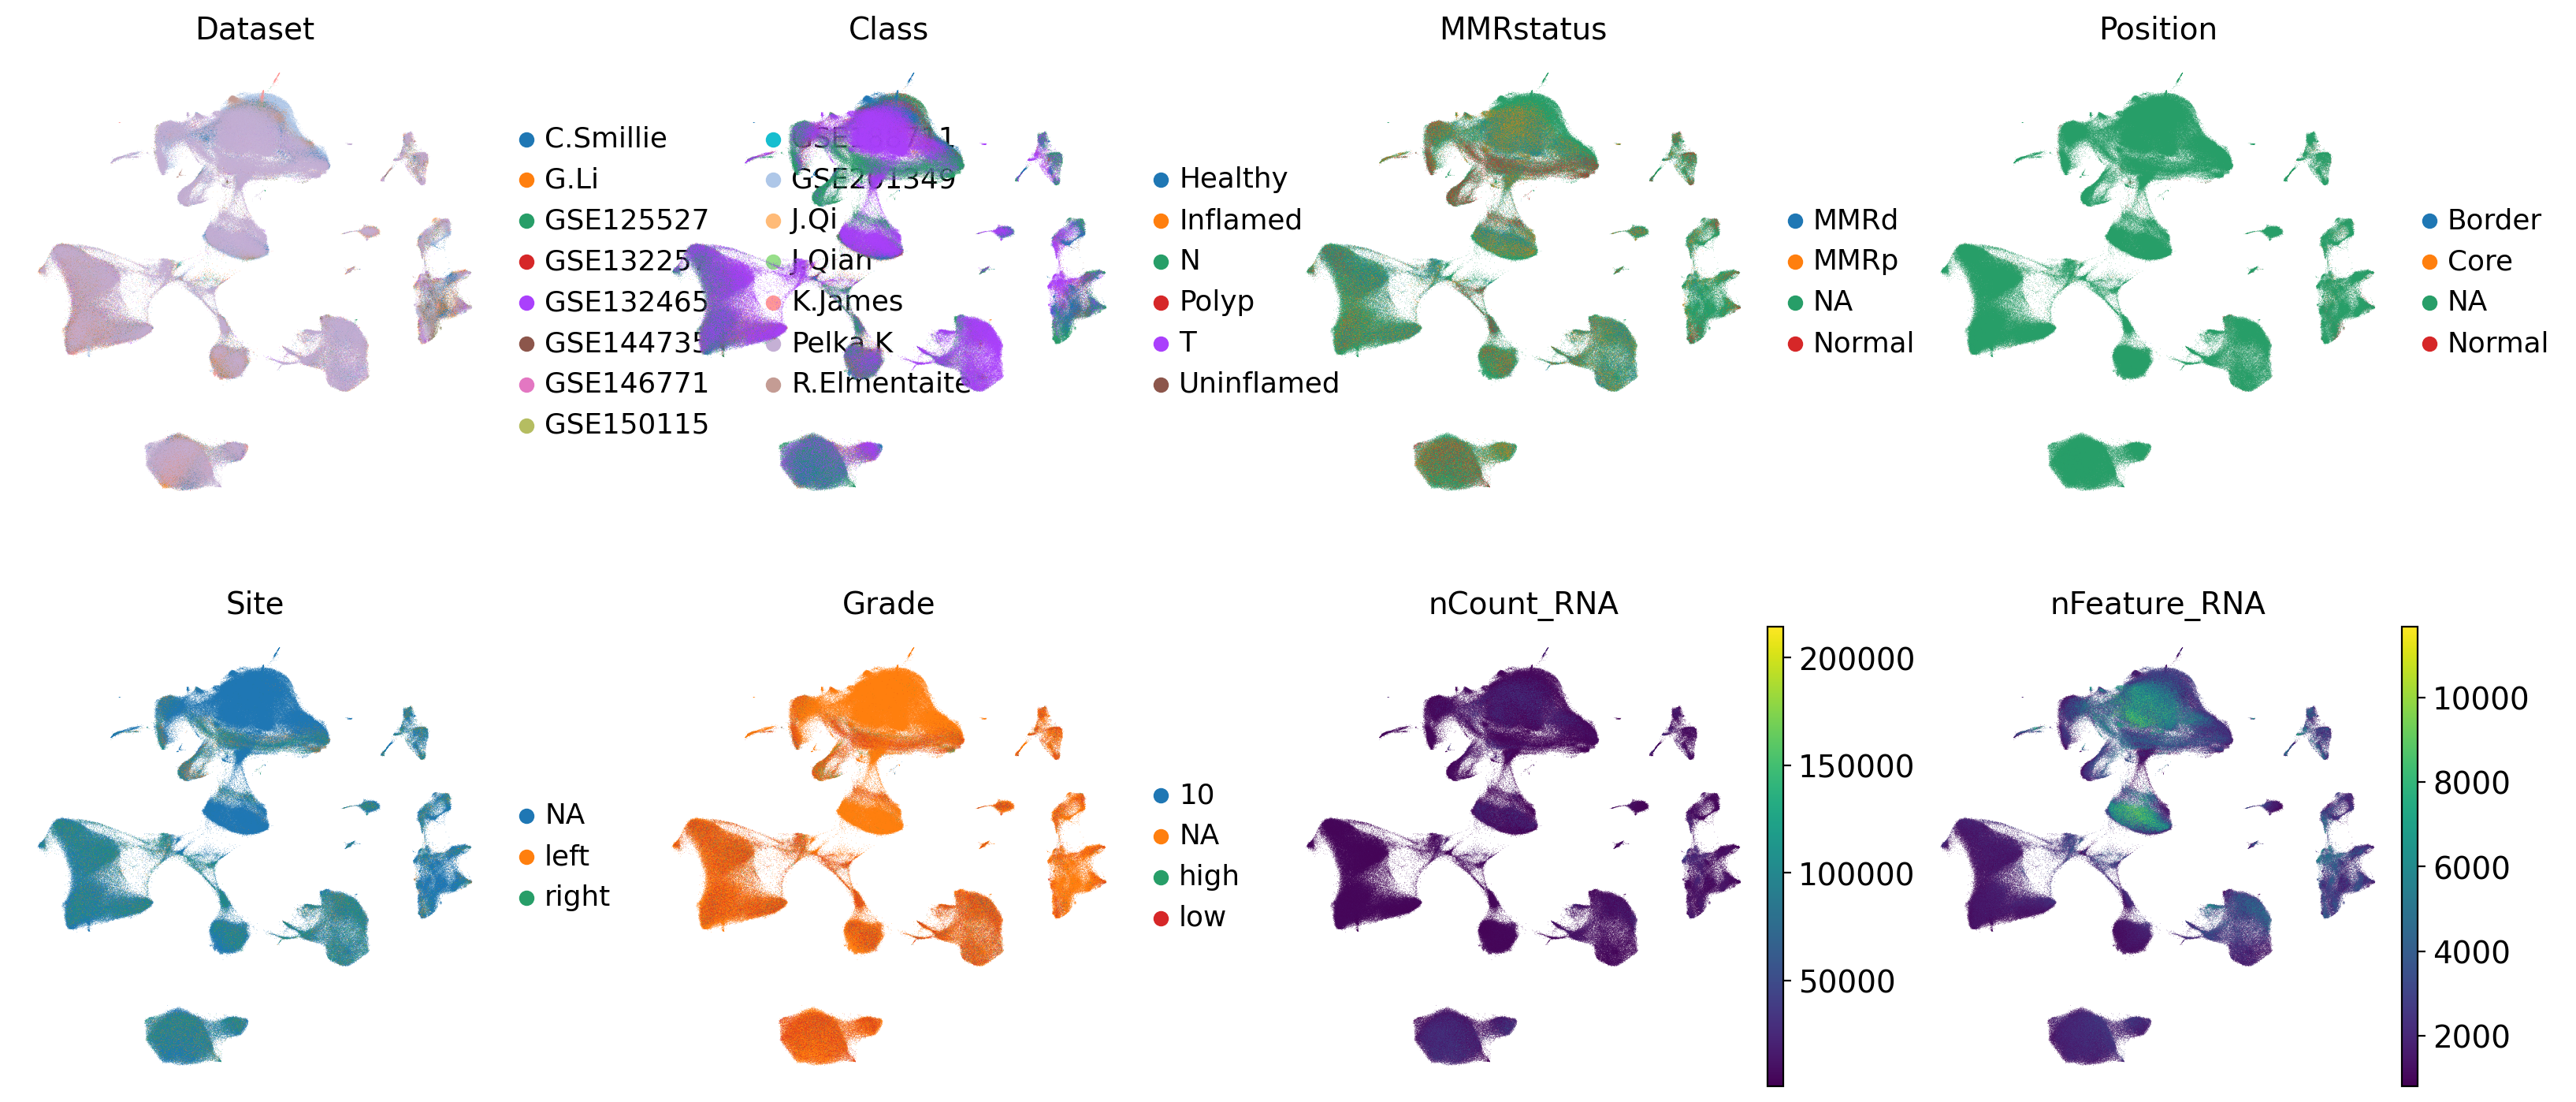

In [14]:
sc.pl.umap(adata, color = ['Dataset', 'Class', 'MMRstatus', 'Position', 'Site', 'Grade', 'nCount_RNA', 'nFeature_RNA'])

# Get Macro/Mono

In [15]:
ad_mac = adata[adata.obs.ParentalCluster == 'Mono/Macro']

In [16]:
ad_mac

View of AnnData object with n_obs × n_vars = 42296 × 51971
    obs: 'Sample', 'Dataset', 'Patient', 'Class', 'SubCluster', 'MMRstatus', 'Position', 'Site', 'Grade', 'GrandparentalCluster', 'ParentalCluster', 'nCount_RNA', 'nFeature_RNA'
    var: 'name'
    uns: 'SubCluster_colors', 'ParentalCluster_colors', 'GrandparentalCluster_colors', 'Dataset_colors', 'Class_colors', 'MMRstatus_colors', 'Position_colors', 'Site_colors', 'Grade_colors'
    obsm: 'X_umap'

for class_type in ad_mac.obs.Class.cat.categories:
    ax = sc.pl.violin(ad_mac[ad_mac.obs.Class == class_type], keys='KOvsWT_up_minus_down_score', groupby='CXCL9_SPP1', rotation = 45, show=False)
    ax.set_title(class_type)
    plt.show()

In [17]:
ad_mac_tumor = ad_mac[ad_mac.obs.Class == 'T']

In [18]:
len(ad_mac_tumor.obs.Sample.unique())

205

In [19]:
database_path = Path('../../../shared/databases/')
numof_genes = 150
KOvsWT_down_genelist = pd.read_csv(database_path / '{}_KO--over--WT_Down-Regulated.csv'.format(numof_genes), header=0).gene_name
KOvsWT_up_genelist = pd.read_csv(database_path / '{}_KO--over--WT_Up-Regulated.csv'.format(numof_genes), header=0).gene_name
KOvsWT_down_genelist = KOvsWT_down_genelist.str.upper()
KOvsWT_up_genelist = KOvsWT_up_genelist.str.upper()

In [20]:
sc.tl.score_genes(ad_mac_tumor, gene_list=KOvsWT_down_genelist, score_name='KOvsWT_down_score')

computing score 'KOvsWT_down_score'
    finished: added
    'KOvsWT_down_score', score of gene set (adata.obs).
    597 total control genes are used. (0:00:21)


In [21]:
sc.tl.score_genes(ad_mac_tumor, gene_list=KOvsWT_up_genelist, score_name='KOvsWT_up_score')

computing score 'KOvsWT_up_score'
    finished: added
    'KOvsWT_up_score', score of gene set (adata.obs).
    796 total control genes are used. (0:00:01)


In [22]:
ad_mac_tumor.obs['KOvsWT_up_minus_down_score'] = ad_mac_tumor.obs['KOvsWT_up_score'] - ad_mac_tumor.obs['KOvsWT_down_score']

In [23]:
df = sc.get.obs_df(ad_mac_tumor, keys = ['SPP1', 'CXCL9'])

In [24]:
#define conditions
conditions = [
    (df['CXCL9'] > 0) & (df['SPP1'] > 0),
    (df['CXCL9'] > 0) & (df['SPP1'] == 0),
    (df['CXCL9'] == 0)& (df['SPP1'] > 0),
    (df['CXCL9'] == 0)& (df['SPP1'] == 0),
]

#define results
results = ['CXCL9 & SPP1', 'CXCL9', 'SPP1', 'none']

#create new column based on conditions in column1 and column2
ad_mac_tumor.obs['CXCL9_SPP1'] = np.select(conditions, results)

In [25]:
Cxcl9_Spp1_colors= {'CXCL9':'#40E0D0', 'SPP1':'#FF1493', 'CXCL9 & SPP1': '#5D29A6', 'none': '#F2F2F2'}

# Fig 1F

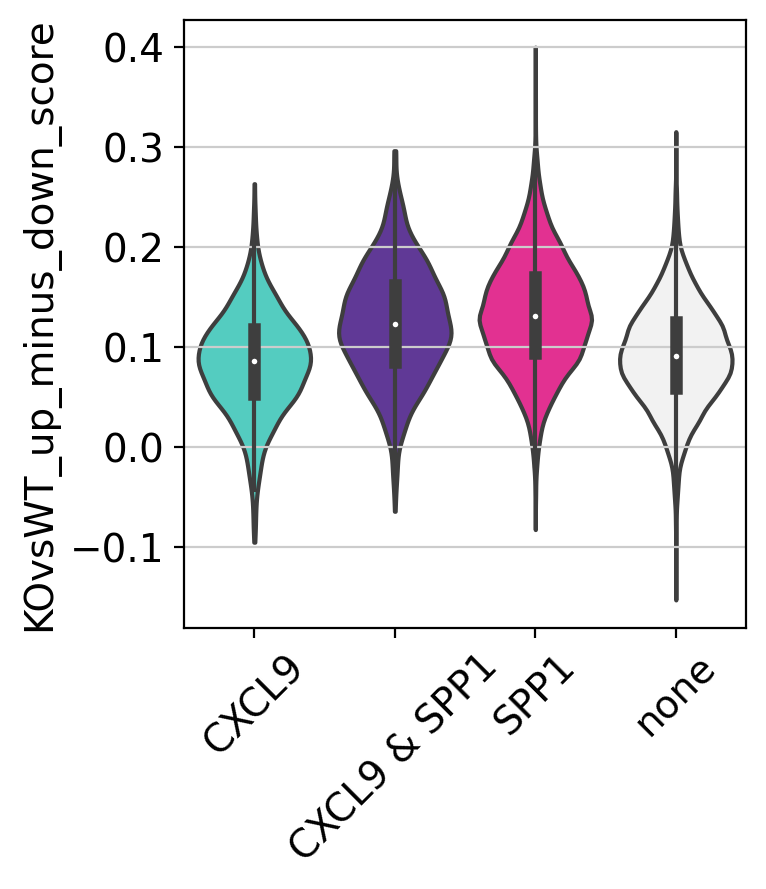

In [26]:
sc.pl.violin(ad_mac_tumor, keys='KOvsWT_up_minus_down_score', groupby='CXCL9_SPP1',  palette = Cxcl9_Spp1_colors, stripplot = False, inner = 'box', rotation = 45)

In [40]:
msigdb = dc.get_resource('MSigDB')
msigdb

genesymbol                          collection  \
0             MAFF  chemical_and_genetic_perturbations   
1             MAFF  chemical_and_genetic_perturbations   
2             MAFF  chemical_and_genetic_perturbations   
3             MAFF                         immunesigdb   
4             MAFF  chemical_and_genetic_perturbations   
...            ...                                 ...   
3838543   PRAMEF22               go_biological_process   
3838544   PRAMEF22               go_biological_process   
3838545   PRAMEF22               go_biological_process   
3838546   PRAMEF22               go_biological_process   
3838547   PRAMEF22               go_biological_process   

                                                   geneset  
0                     BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN  
1                                       ELVIDGE_HYPOXIA_UP  
2                                 NUYTTEN_NIPP1_TARGETS_DN  
3                GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN  
4                   SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP  
...                                                    ...  
3838543  GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...  
3838544                             GOBP_APOPTOTIC_PROCESS  
3838545                      GOBP_REGULATION_OF_CELL_DEATH  
3838546  GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS  
3838547             GOBP_NEGATIVE_REGULATION_OF_CELL_DEATH  

[3838548 rows x 3 columns]

In [41]:
msigdb['collection'].unique()

['chemical_and_genetic_perturbations', 'immunesigdb', 'mirna_targets_mirdb', 'go_molecular_function', 'tf_targets_gtrf', ..., 'biocarta_pathways', 'positional', 'human_phenotype_ontology', 'pid_pathways', 'kegg_pathways']
Length: 22
Categories (22, string): [biocarta_pathways, cancer_gene_neighborhoods, cancer_modules, cell_type_signatures, ..., tf_targets_gtrf, tf_targets_legacy, vaccine_response, wikipathways]

In [42]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

genesymbol collection                           geneset
233           MAFF   hallmark      HALLMARK_IL2_STAT5_SIGNALING
250           MAFF   hallmark              HALLMARK_COAGULATION
270           MAFF   hallmark                  HALLMARK_HYPOXIA
373           MAFF   hallmark  HALLMARK_TNFA_SIGNALING_VIA_NFKB
377           MAFF   hallmark               HALLMARK_COMPLEMENT
...            ...        ...                               ...
1449668     STXBP1   hallmark      HALLMARK_PANCREAS_BETA_CELLS
1450315       ELP4   hallmark      HALLMARK_PANCREAS_BETA_CELLS
1450526        GCG   hallmark      HALLMARK_PANCREAS_BETA_CELLS
1450731      PCSK2   hallmark      HALLMARK_PANCREAS_BETA_CELLS
1450916       PAX6   hallmark      HALLMARK_PANCREAS_BETA_CELLS

[7318 rows x 3 columns]

In [43]:
msigdb.geneset = msigdb.geneset.str.replace('HALLMARK_', '')

In [44]:
msigdb

genesymbol collection                  geneset
233           MAFF   hallmark      IL2_STAT5_SIGNALING
250           MAFF   hallmark              COAGULATION
270           MAFF   hallmark                  HYPOXIA
373           MAFF   hallmark  TNFA_SIGNALING_VIA_NFKB
377           MAFF   hallmark               COMPLEMENT
...            ...        ...                      ...
1449668     STXBP1   hallmark      PANCREAS_BETA_CELLS
1450315       ELP4   hallmark      PANCREAS_BETA_CELLS
1450526        GCG   hallmark      PANCREAS_BETA_CELLS
1450731      PCSK2   hallmark      PANCREAS_BETA_CELLS
1450916       PAX6   hallmark      PANCREAS_BETA_CELLS

[7318 rows x 3 columns]

In [45]:
dc.run_aucell(ad_mac_tumor, msigdb, source='geneset', target='genesymbol', use_raw=False)

In [46]:
terms = msigdb.geneset.unique()

In [47]:
ad_mac_tumor.obsm['aucell_estimate']

source                                     ADIPOGENESIS  ALLOGRAFT_REJECTION  \
scrEXT001_AAACCTGTCACCACCT_1                   0.098965             0.092585   
scrEXT001_AAAGATGAGAGTGACC_1                   0.134837             0.129281   
scrEXT001_AAAGATGTCACCCGAG_1                   0.112381             0.113294   
scrEXT001_AAAGTAGAGGGAACGG_1                   0.102773             0.150577   
scrEXT001_AAATGCCTCAGGATCT_1                   0.094624             0.132564   
...                                                 ...                  ...   
C173_T_0_0_0_c1_v3_id-TTGGTTTCACATACGT_15      0.086836             0.133886   
C173_T_0_0_0_c1_v3_id-TTGTTTGGTTGACTAC_15      0.065442             0.162865   
C173_T_0_0_0_c1_v3_id-TTTATGCTCTATCACT_15      0.091815             0.107573   
C173_T_0_0_0_c1_v3_id-TTTCACACATGACGAG_15      0.113324             0.139704   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC_15      0.086761             0.173405   

source                                     ANDROGEN_RESPONSE  ANGIOGENESIS  \
scrEXT001_AAACCTGTCACCACCT_1                        0.163935      0.174894   
scrEXT001_AAAGATGAGAGTGACC_1                        0.115357      0.102009   
scrEXT001_AAAGATGTCACCCGAG_1                        0.126061      0.089766   
scrEXT001_AAAGTAGAGGGAACGG_1                        0.139972      0.141581   
scrEXT001_AAATGCCTCAGGATCT_1                        0.107779      0.096336   
...                                                      ...           ...   
C173_T_0_0_0_c1_v3_id-TTGGTTTCACATACGT_15           0.168025      0.205052   
C173_T_0_0_0_c1_v3_id-TTGTTTGGTTGACTAC_15           0.142222      0.177653   
C173_T_0_0_0_c1_v3_id-TTTATGCTCTATCACT_15           0.144758      0.066644   
C173_T_0_0_0_c1_v3_id-TTTCACACATGACGAG_15           0.156177      0.064281   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC_15           0.152740      0.109889   

source                                     APICAL_JUNCTION  APICAL_SURFACE  \
scrEXT001_AAACCTGTCACCACCT_1                      0.069438        0.048523   
scrEXT001_AAAGATGAGAGTGACC_1                      0.060612        0.041827   
scrEXT001_AAAGATGTCACCCGAG_1                      0.086838        0.024128   
scrEXT001_AAAGTAGAGGGAACGG_1                      0.084918        0.051745   
scrEXT001_AAATGCCTCAGGATCT_1                      0.065251        0.024395   
...                                                    ...             ...   
C173_T_0_0_0_c1_v3_id-TTGGTTTCACATACGT_15         0.096647        0.037015   
C173_T_0_0_0_c1_v3_id-TTGTTTGGTTGACTAC_15         0.090034        0.064984   
C173_T_0_0_0_c1_v3_id-TTTATGCTCTATCACT_15         0.050784        0.029868   
C173_T_0_0_0_c1_v3_id-TTTCACACATGACGAG_15         0.093666        0.034919   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC_15         0.102340        0.087269   

source                                     APOPTOSIS  BILE_ACID_METABOLISM  \
scrEXT001_AAACCTGTCACCACCT_1                0.154962              0.042628   
scrEXT001_AAAGATGAGAGTGACC_1                0.165095              0.042628   
scrEXT001_AAAGATGTCACCCGAG_1                0.140087              0.040355   
scrEXT001_AAAGTAGAGGGAACGG_1                0.175133              0.032401   
scrEXT001_AAATGCCTCAGGATCT_1                0.147456              0.019770   
...                                              ...                   ...   
C173_T_0_0_0_c1_v3_id-TTGGTTTCACATACGT_15   0.117404              0.028510   
C173_T_0_0_0_c1_v3_id-TTGTTTGGTTGACTAC_15   0.185893              0.040995   
C173_T_0_0_0_c1_v3_id-TTTATGCTCTATCACT_15   0.080836              0.024609   
C173_T_0_0_0_c1_v3_id-TTTCACACATGACGAG_15   0.119830              0.028746   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC_15   0.146582              0.025597   

source                                     CHOLESTEROL_HOMEOSTASIS  \
scrEXT001_AAACCTGTCACCACCT_1                              0.121490   
scrEXT001_AAAGATGAGAGTGACC_1                              0.125194   
scrEXT001_AAAGATGT

In [48]:
ad_mac_tumor.obs[terms] = ad_mac_tumor.obsm["aucell_estimate"][terms]

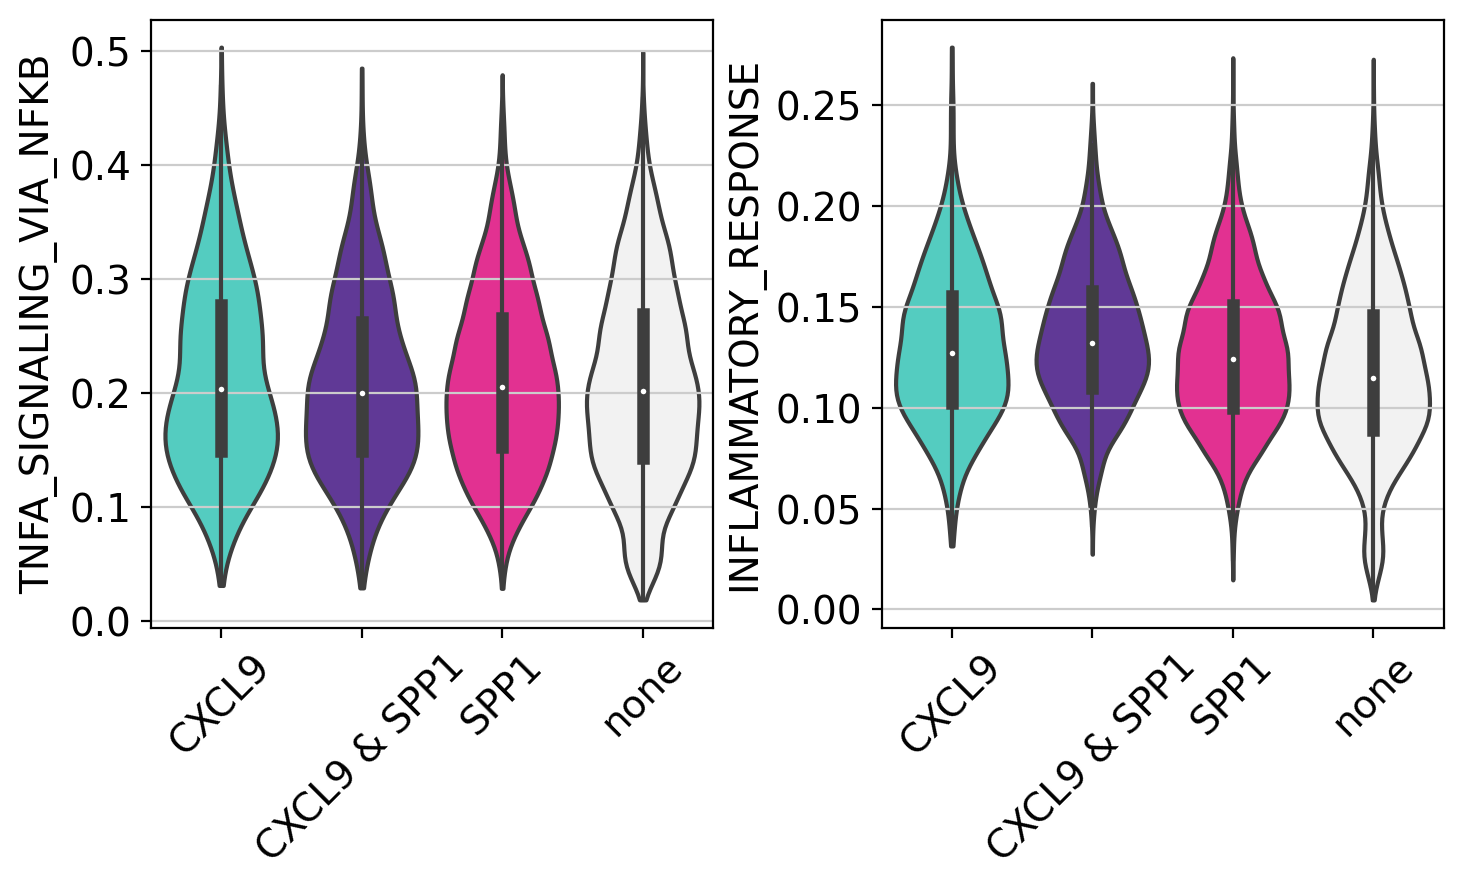

In [68]:
sc.pl.violin(ad_mac_tumor, keys=important_terms, groupby='CXCL9_SPP1',  palette = Cxcl9_Spp1_colors, stripplot = False, inner = 'box', rotation = 45)

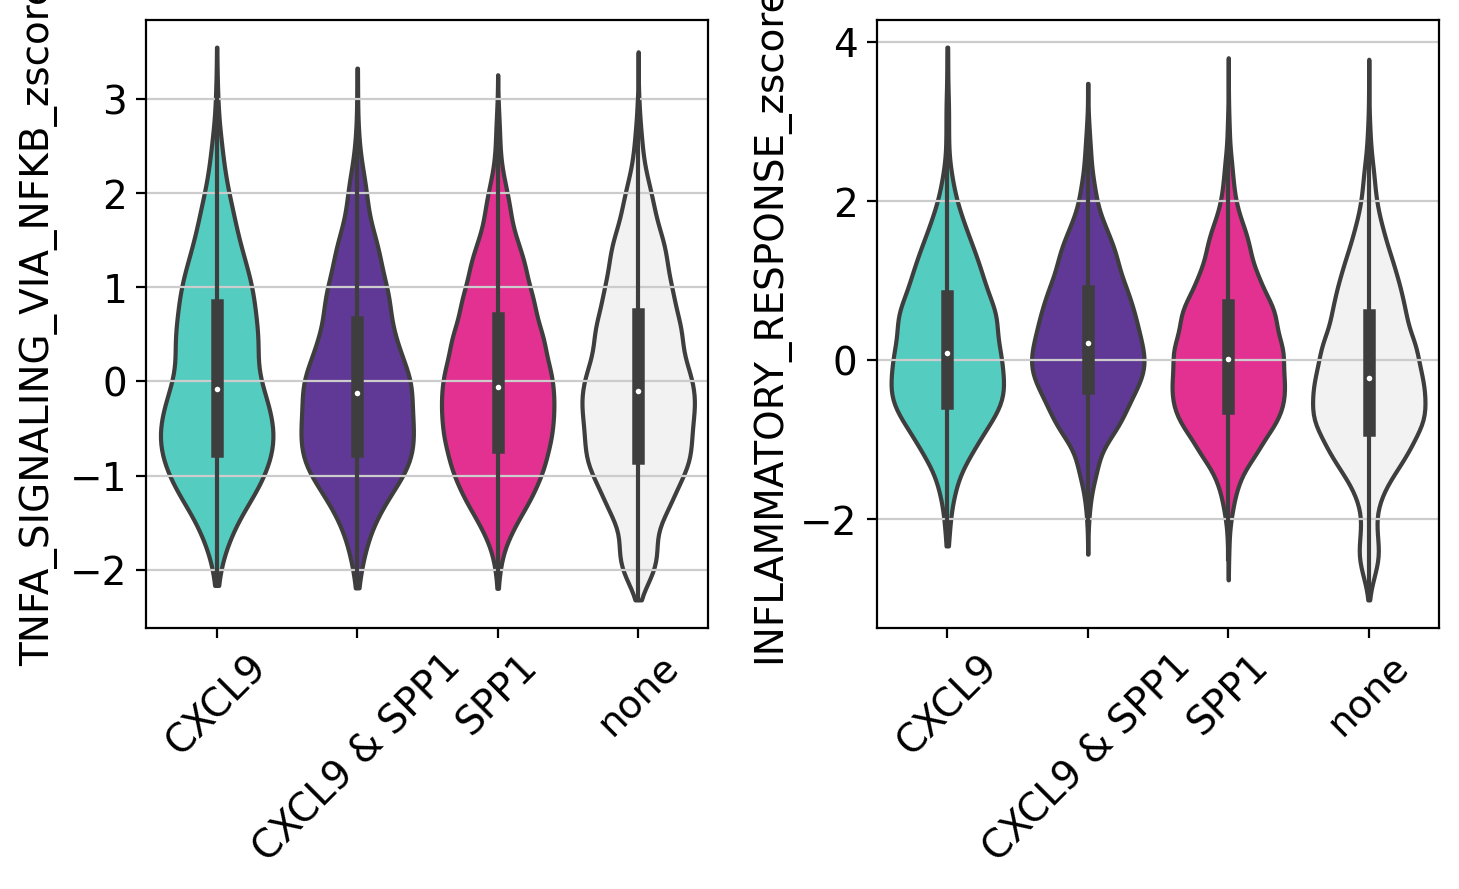

In [69]:
sc.pl.violin(ad_mac_tumor, keys=zscore_important_terms, groupby='CXCL9_SPP1',  palette = Cxcl9_Spp1_colors, stripplot = False, inner = 'box', rotation = 45)

In [49]:
terms

array(['IL2_STAT5_SIGNALING', 'COAGULATION', 'HYPOXIA',
       'TNFA_SIGNALING_VIA_NFKB', 'COMPLEMENT', 'P53_PATHWAY',
       'GLYCOLYSIS', 'APOPTOSIS', 'EPITHELIAL_MESENCHYMAL_TRANSITION',
       'PROTEIN_SECRETION', 'ADIPOGENESIS', 'BILE_ACID_METABOLISM',
       'INFLAMMATORY_RESPONSE', 'UNFOLDED_PROTEIN_RESPONSE',
       'TGF_BETA_SIGNALING', 'KRAS_SIGNALING_UP', 'UV_RESPONSE_UP',
       'ALLOGRAFT_REJECTION', 'INTERFERON_GAMMA_RESPONSE',
       'INTERFERON_ALPHA_RESPONSE', 'IL6_JAK_STAT3_SIGNALING',
       'XENOBIOTIC_METABOLISM', 'ESTROGEN_RESPONSE_LATE',
       'KRAS_SIGNALING_DN', 'MYC_TARGETS_V2',
       'WNT_BETA_CATENIN_SIGNALING', 'NOTCH_SIGNALING',
       'CHOLESTEROL_HOMEOSTASIS', 'ANGIOGENESIS', 'HEDGEHOG_SIGNALING',
       'MYOGENESIS', 'APICAL_JUNCTION', 'G2M_CHECKPOINT',
       'ANDROGEN_RESPONSE', 'UV_RESPONSE_DN', 'MYC_TARGETS_V1',
       'E2F_TARGETS', 'ESTROGEN_RESPONSE_EARLY', 'MTORC1_SIGNALING',
       'HEME_METABOLISM', 'PI3K_AKT_MTOR_SIGNALING',
       'FATTY_A

In [50]:
important_terms = ['TNFA_SIGNALING_VIA_NFKB', 'INFLAMMATORY_RESPONSE']

In [51]:
zscore_important_terms = [ term + '_zscore' for term in important_terms]

In [52]:
for term, zscore_term in zip(important_terms, zscore_important_terms):
    ad_mac_tumor.obs[zscore_term] = scipy.stats.zscore(ad_mac_tumor.obs[term])

categories_order = sorted(ad_mac_tumor.obs['sample'].cat.categories.tolist(), key = lambda x: x.split('_Day')[1]) # sort by day

In [ ]:
print(categories_order)

In [56]:
ad_mac_tumor.obs_keys()

['Sample',
 'Dataset',
 'Patient',
 'Class',
 'SubCluster',
 'MMRstatus',
 'Position',
 'Site',
 'Grade',
 'GrandparentalCluster',
 'ParentalCluster',
 'nCount_RNA',
 'nFeature_RNA',
 'KOvsWT_down_score',
 'KOvsWT_up_score',
 'KOvsWT_up_minus_down_score',
 'CXCL9_SPP1',
 'IL2_STAT5_SIGNALING',
 'COAGULATION',
 'HYPOXIA',
 'TNFA_SIGNALING_VIA_NFKB',
 'COMPLEMENT',
 'P53_PATHWAY',
 'GLYCOLYSIS',
 'APOPTOSIS',
 'EPITHELIAL_MESENCHYMAL_TRANSITION',
 'PROTEIN_SECRETION',
 'ADIPOGENESIS',
 'BILE_ACID_METABOLISM',
 'INFLAMMATORY_RESPONSE',
 'UNFOLDED_PROTEIN_RESPONSE',
 'TGF_BETA_SIGNALING',
 'KRAS_SIGNALING_UP',
 'UV_RESPONSE_UP',
 'ALLOGRAFT_REJECTION',
 'INTERFERON_GAMMA_RESPONSE',
 'INTERFERON_ALPHA_RESPONSE',
 'IL6_JAK_STAT3_SIGNALING',
 'XENOBIOTIC_METABOLISM',
 'ESTROGEN_RESPONSE_LATE',
 'KRAS_SIGNALING_DN',
 'MYC_TARGETS_V2',
 'WNT_BETA_CATENIN_SIGNALING',
 'NOTCH_SIGNALING',
 'CHOLESTEROL_HOMEOSTASIS',
 'ANGIOGENESIS',
 'HEDGEHOG_SIGNALING',
 'MYOGENESIS',
 'APICAL_JUNCTION',
 'G2M_C

In [57]:
obs_df = sc.get.obs_df(ad_mac_tumor, keys=zscore_important_terms + ['CXCL9_SPP1'])

sc.pl.matrixplot(adata_tc, zscore_important_terms, categories_order= categories_order, groupby='sample', vcenter = 0, swap_axes=True, cmap='coolwarm')

sc.pl.dotplot(adata_tc, zscore_important_terms, categories_order= categories_order, groupby='sample', vcenter = 0, swap_axes=True, cmap='coolwarm')

In [59]:
important_terms_zscores_samples = sc.get.obs_df(ad_mac_tumor, keys=zscore_important_terms + ['CXCL9_SPP1'])

In [60]:
mean_scores = important_terms_zscores_samples.groupby('CXCL9_SPP1').mean()

In [61]:
mean_scores

TNFA_SIGNALING_VIA_NFKB_zscore  INFLAMMATORY_RESPONSE_zscore
CXCL9_SPP1                                                                
CXCL9                               0.054641                      0.162249
CXCL9 & SPP1                       -0.024595                      0.280552
SPP1                                0.020737                      0.078530
none                               -0.026913                     -0.159798

In [ ]:
mean_scores.loc['Control', :]

In [ ]:
mean_scores.index.get_level_values(level='stimulation').unique()

In [ ]:
stim_order = ['Control', 'IFNy', 'IL10', 'TGFb', 'IL4', 'TC']

In [ ]:
stim_order

In [ ]:
print(mean_scores)

In [62]:
mean_scores_reset = mean_scores.reset_index()


In [64]:
mean_scores_long = mean_scores_reset.melt(
    id_vars='CXCL9_SPP1',
    var_name='Pathway',
    value_name='mean_zscore'
)

In [65]:
mean_scores_long

CXCL9_SPP1                         Pathway  mean_zscore
0         CXCL9  TNFA_SIGNALING_VIA_NFKB_zscore     0.054641
1  CXCL9 & SPP1  TNFA_SIGNALING_VIA_NFKB_zscore    -0.024595
2          SPP1  TNFA_SIGNALING_VIA_NFKB_zscore     0.020737
3          none  TNFA_SIGNALING_VIA_NFKB_zscore    -0.026913
4         CXCL9    INFLAMMATORY_RESPONSE_zscore     0.162249
5  CXCL9 & SPP1    INFLAMMATORY_RESPONSE_zscore     0.280552
6          SPP1    INFLAMMATORY_RESPONSE_zscore     0.078530
7          none    INFLAMMATORY_RESPONSE_zscore    -0.159798

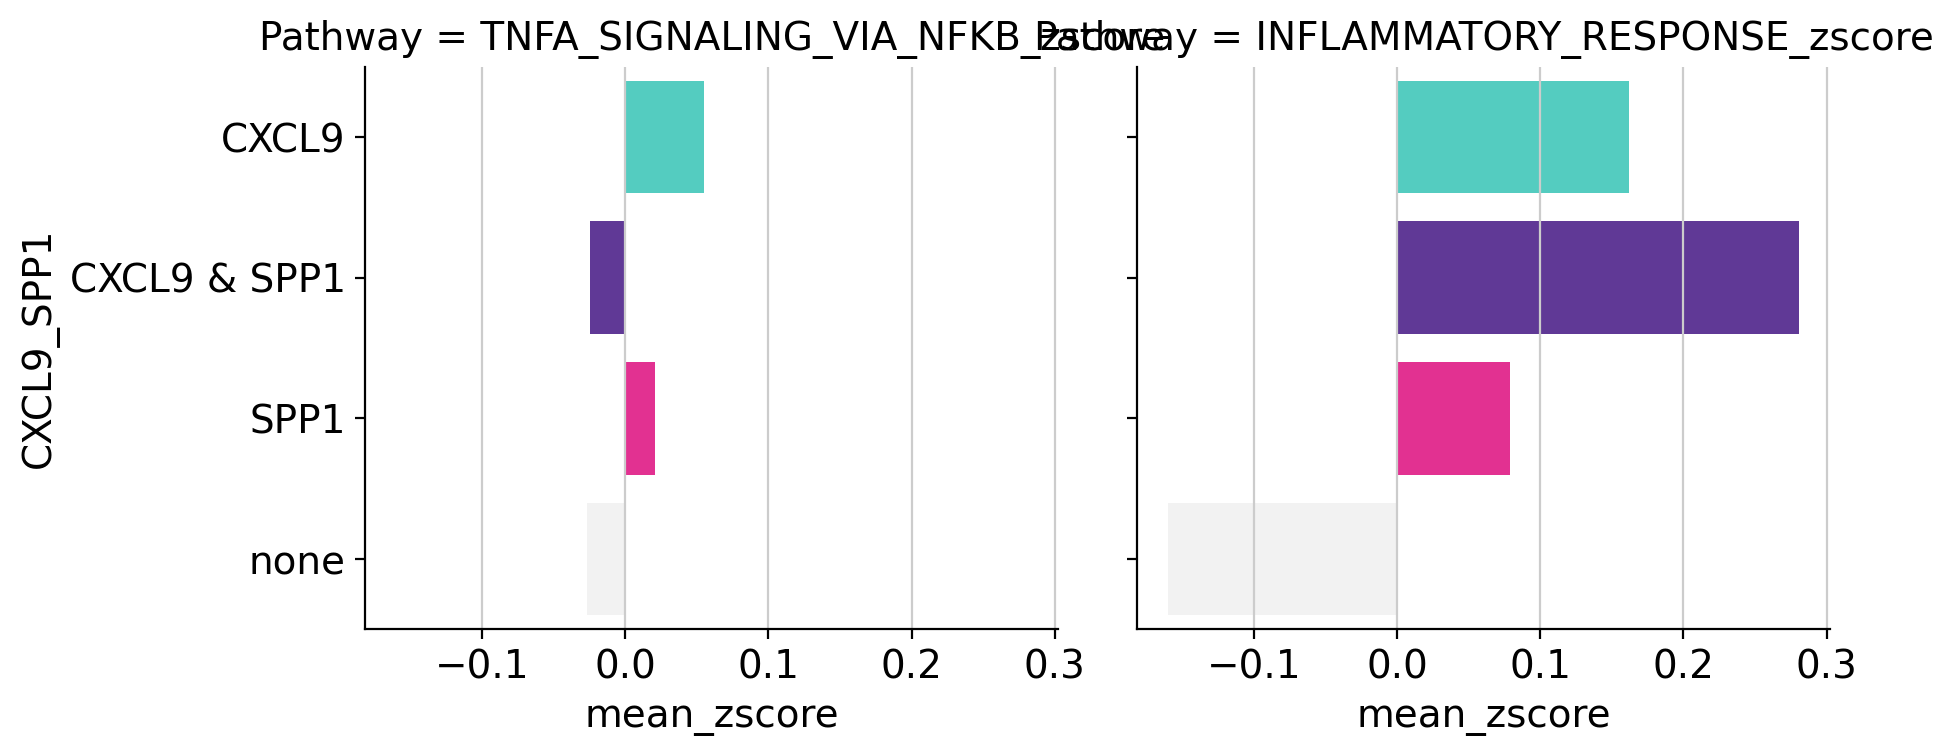

In [74]:
facet_grid = sns.catplot(
    data=mean_scores_long,
    y='CXCL9_SPP1',
    x= 'mean_zscore',
    #hue='day',
    col='Pathway',
    kind='bar',
    orient='h',
    height=4,
    aspect=1.2,
   # order = stim_order,
   palette= Cxcl9_Spp1_colors
)
facet_grid.savefig(path_to_results / 'barplot_mean_zscores.pdf')

In [ ]:
for term in zscore_important_terms:
    df_to_plot = mean_scores[term].unstack()
    df_to_plot.reindex(stim_order).plot.barh(title = term)

mean_std = important_terms_zscores_samples.groupby(['stimulation', 'day']).agg(['mean', 'std'])
mean_std.columns = ['_'.join(col).strip() for col in mean_std.columns.values]
mean_std = mean_std.reset_index()

mean_melt = mean_std.melt(
    id_vars=['stimulation', 'day'],
    value_vars=[col for col in mean_std.columns if col.endswith('_mean')],
    var_name='Pathway',
    value_name='Z_Score_Mean'
)

std_melt = mean_std.melt(
    id_vars=['stimulation', 'day'],
    value_vars=[col for col in mean_std.columns if col.endswith('_std')],
    var_name='Pathway',
    value_name='Z_Score_Std'
)

mean_melt['Pathway'] = mean_melt['Pathway'].str.replace('_mean', '')
std_melt['Pathway'] = std_melt['Pathway'].str.replace('_std', '')

plot_df = pd.merge(mean_melt, std_melt, on=['stimulation', 'day', 'Pathway'])

# Plot
g = sns.catplot(
    data=plot_df,
    x='Z_Score_Mean',
    y='stimulation',
    hue='day',
    col='Pathway',
    kind='bar',
    height=5,
    aspect=0.9,
    orient='h',
    order=stim_order,
    errorbar=None  # disable built-in CI
)

# Manually add error bars
for ax, pathway in zip(g.axes[0], plot_df['Pathway'].unique()):
    subset = plot_df[plot_df['Pathway'] == pathway]
    for i, (_, row) in enumerate(subset.iterrows()):
        stim = row['stimulation']
        y_pos = stim_order.index(stim)
        ax.errorbar(
            x=row['Z_Score_Mean'],
            y=y_pos + (0.2 if row['day'] == 1 else -0.2),  # offset for hue separation
            xerr=row['Z_Score_Std'],
            fmt='none',
            ecolor='black',
            capsize=3,
            elinewidth=1
        )

# Titles and labels
g.set_titles(col_template='{col_name}', size=12)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Mean Z-Scores with Std Error by Stimulation and Pathway', fontsize=16)
g.set_axis_labels("Mean Z-Score", "Stimulation")

plt.show()